<a href="https://colab.research.google.com/github/PedroCanoM/Idal_ia3/blob/main/Sea_Ice_Extent_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Read and clean the data.
Load the monthly sea ice extent (SIE) monthly data provided in the file 'SeaIce.txt'. Note variables ``extent`` (SIE) and ``area`` should be greater or equal than zero. Detect possible outliers and clean the data.  


### Climate Change and Sea Ice Extent

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements (in millions of square km) from the [National Snow & Ice Data Center](https://nsidc.org).

We perform the following processing steps:
1. Read and clean the data.
2. Normalize the Sea Ice Extent (SIE) data and visualize its temporal trend.
3. Compute the SIE temporal trend as a simple linear regression (OLS) and quantitatively evaluate it.
4. Estimate the sea ice extent for 2025.


In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import datetime as dt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
#cargamos los datos
df = pd.read_csv('SeaIce.txt', sep='\s+')
df.head()

,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       424 non-null    int64  
 1   mo         424 non-null    int64  
 2   data_type  424 non-null    object 
 3   region     424 non-null    object 
 4   extent     424 non-null    float64
 5   area       424 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 20.0+ KB


In [5]:
#La unidad de las observaciones en extent y area es el millon de kilómetros cuadrados.
#Que sean floats podría indicarnos que no incluyen valores extraños. Después buscaremos outlaiers.
#Comprobamos que no hayan valores extraños en las otras columnas.
for col in ['year', 'mo', 'data_type', 'region']:
    print(f'Columna {col}:')
    print(df[col].value_counts(), '\n')

Columna year:
1996    12
1988    12
1994    12
1993    12
1992    12
1991    12
1990    12
1989    12
1987    12
2013    12
1986    12
1985    12
1984    12
1983    12
1982    12
1981    12
1995    12
1997    12
1979    12
2006    12
2012    12
2011    12
2010    12
2009    12
2008    12
2007    12
2005    12
1998    12
2004    12
2003    12
2002    12
2001    12
2000    12
1999    12
1980    12
2014     2
1978     2
Name: year, dtype: int64 

Columna mo:
12    36
11    36
2     36
1     36
10    35
9     35
8     35
7     35
6     35
5     35
4     35
3     35
Name: mo, dtype: int64 

Columna data_type:
Goddard    409
NRTSI-G     13
-9999        2
Name: data_type, dtype: int64 

Columna region:
N    424
Name: region, dtype: int64 



In [6]:
#Observamos que las entradas en las columnas de año y mes tienen sentido. 
#La columna region no es informativa.
#En la columna data_type nos indican cuales han sido los datos diarios en los que se ha basado el cálculo de los
# valores mensuales (https://nsidc.org/sites/nsidc.org/files/G02135-V3.0_0.pdf#18). Existen tres observaciones, dos 
# (Goddarm, NRTSI-G) válidas y otra (-9999) que es un error. Quitamos estas últimas.
df=df[df['data_type'] != '-9999']
df['data_type'].value_counts()

Goddard    409
NRTSI-G     13
Name: data_type, dtype: int64

In [7]:
#Buscamos outlaiers en extent y area. Consideraremos outlaiers aquellos valores que se alejen 1.5 veces el rango intercuartílico por debajo de Q1 y por arriba de Q3
def get_outlaiers(x):
    q1, q3 = x.quantile((0.25, 0.75))
    iqr = q3 - q1

    return(x[(x < q1 -  1.5*iqr) | (x > q3 +  1.5*iqr)])

print(len(get_outlaiers(df['extent'])), len(get_outlaiers(df['area'])))
#No encontramos outlaiers.

0 0


In [8]:
#Quitamos la columna region.
del df['region']
df.head()

,year,mo,data_type,extent,area
0,1979,1,Goddard,15.54,12.33
1,1980,1,Goddard,14.96,11.85
2,1981,1,Goddard,15.03,11.82
3,1982,1,Goddard,15.26,12.11
4,1983,1,Goddard,15.10,11.92


In [9]:
#Añadimos una columna con las fechas
dates = df.iloc[:,0:2].copy()
dates.columns = ['year', 'month']
dates['day']=[1]*len(dates)

df['date']=pd.to_datetime(dates, format="")
df.head(25)

,year,mo,data_type,extent,area,date
0,1979,1,Goddard,15.54,12.33,1979-01-01
1,1980,1,Goddard,14.96,11.85,1980-01-01
2,1981,1,Goddard,15.03,11.82,1981-01-01
3,1982,1,Goddard,15.26,12.11,1982-01-01
4,1983,1,Goddard,15.10,11.92,1983-01-01
5,1984,1,Goddard,14.61,11.60,1984-01-01
6,1985,1,Goddard,14.86,11.60,1985-01-01
7,1986,1,Goddard,15.02,11.79,1986-01-01
8,1987,1,Goddard,15.20,11.81,1987-01-01
10,1989,1,Goddard,15.12,13.11,1989-01-01


In [10]:
#reiniciamos los índices
df=df.reset_index()
del df['index']

### 2. Normalize the SIE data and visualize its temporal trend.

Visualize there is a monthly dependence of SIE, explore the linear relationship using ``lmplot``.
Compute the mean and variance of SIE for each month.

In [11]:
#Comenzamos presentando algunas gráficas para visualizar la evolución de extend por meses (dentro de cada año),
#y por años (durante todo el periodo de estudio).

years = df.sort_values('year').year.unique()
months = np.arange(12) + 1
z = []

for year in years:
    aux = []
    for month in months:
        try:
            aux.append(df[(df['year'] == year) & (df['mo'] == month)]['extent'].iloc[0])
        except:
            aux.append(None)
    z.append(aux)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=months,
    y = years,
    colorscale = 'Ice'
    ))
fig.layout.height = 950
fig.show()

#En el mapa de calor vemos como los valores más pequeños de SIE se dan en los últimos meses del verano (agosto y septiembre),
#mientras que los mayores se encuentran en los últimos meses del invierno (febrero, marzo).
#Los cambios entre valores máximos y mínimos no parecen ocurrir bruscamente.
#Respecto al desarrollo por años, podemos ver como, en los últimos años del estudio, la cantidad de hielo ha
#disminuido respecto a los primeros. Esta variación es más evidente en los meses de verano.
#

In [12]:
#Ahora mostraremos la distribución durante un año y la mensual a lo largo de todos los años en gráficas dinámicas.
#Para ellos eliminamos los años con pocos datos y completamos los que casi tengan 12.

#identificamos los años con algún mes faltante
aux = df['year'].value_counts()
ms = aux[aux.values<12]
ys = df[df['year'].isin(ms.index)]['year'].unique()

#identificamos los meses faltantes
months = set(np.arange(12) + 1)
empty_y_m=dict()
for y in ys:
    empty_months = months - set(df['mo'][df['year'] == y])
    empty_y_m[y] = empty_months

print(empty_y_m)
    

{1987: {12}, 2014: {3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 1988: {1}, 1978: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}}


In [13]:
#Consideramos que a 2014 y a 1978, les faltan demasiados meses y eliminamos esas observaciones.
df1 = df[~df['year'].isin((2014, 1978))].copy()
df1 = df1.reset_index(drop=True)
print(len(df1))
df1.tail()

418


,year,mo,data_type,extent,area,date
413,2009,12,Goddard,12.51,10.25,2009-12-01
414,2010,12,Goddard,12.02,10.08,2010-12-01
415,2011,12,Goddard,12.40,10.28,2011-12-01
416,2012,12,Goddard,12.20,10.11,2012-12-01
417,2013,12,NRTSI-G,12.38,10.48,2013-12-01


In [14]:
del empty_y_m[2014]
del empty_y_m[1978]

In [15]:
#A 1987 y a 1988 les faltan diciembre y enero respectivamente. Añadiremos esas observaciones asignando a extent y a area la media de los valores
#de esos mismos meses los 6 años de alrededor.

for y, ms in empty_y_m.items():
  for m in ms: #en caso de que hubiera más de un mes

    e = df1['extent'][(df1['year'].isin(range(y-3, y+4))) & (df1['mo'] == m)].mean()
    a = df1['area'][(df1['year'].isin(range(y-3, y+4))) & (df1['mo'] == m)].mean()

    df1.loc[len(df1)] = [y, m, 'Created', e, a, pd.Timestamp(year = y, month = m, day =1 )]

print(len(df1))
df1.tail()


420


,year,mo,data_type,extent,area,date
415,2011,12,Goddard,12.400000,10.280000,2011-12-01
416,2012,12,Goddard,12.200000,10.110000,2012-12-01
417,2013,12,NRTSI-G,12.380000,10.480000,2013-12-01
418,1987,12,Created,13.381667,10.945000,1987-12-01
419,1988,1,Created,14.935000,12.253333,1988-01-01


In [16]:
df1 = df1.sort_values('date')
px.line(df1, x = 'mo', y = 'extent',
  animation_frame = "year", 
  range_y=[df1['extent'].min()-0.25, df1['extent'].max()+0.25],
  labels = {'mo' : 'Month', 'extent' : 'Extent', 'year' : 'Year'} )

#Vemos la evolución dentro de cada año. Comprovamos que es 
#aparentemente suave y periódica de invierno a invierno.
#El máximo de SIE se da en marzo y el mínimo en septiembre, la mayoría de años.
#Si avanzamos en el tiempo, apreciamos como la SIE de cada mes 
#se ha ido reduciendo con el paso del tiempo, pese a presentar fluctuaciones año
#a año. 

In [17]:
px.scatter(df1, x = 'year', y = 'extent',
  animation_frame = "mo", 
  range_y=[df1['extent'].min()-0.25,df1['extent'].max()+0.25],
  labels = {'mo': 'Month', 'extent':'Extent', 'year':'Year'})

#Vemos la evolución de cada mes a lo largo de todo el periodo de estudio.
#Confirmando lo que veíamos antes, el SIE de cada mes ha disminuido a lo largo del
#del tiempo, siguiendo una evolución oscilatoria.
#La animación evidencia tendencia estacional.

In [18]:
px.scatter(df1, x = 'year', y = 'extent',
  animation_frame = "mo", opacity = 0.65,
  trendline='ols', trendline_color_override='darkblue',
  range_y=[df1['extent'].min()-0.25,df1['extent'].max()+0.25],
  labels = {'mo': 'Month', 'extent':'Extent', 'year':'Year'})
#También podemos obtener las gráficas anteriores, añadiendo un 
#ajuste por mínimos cuadrados. Todas las rectas tienen pendiente
#negativa, lo que apoya la idea de que el SIE se ha ido reduciendo
#con los años.
#Como esperábamos, la recta con las imágenes más altas es la correspondiente
#a marzo, y la más baja, la de septiembre. Además, esta última es la que tiene la 
#pendiente más pronunciada.
#

In [19]:
#Dibujamos a continuación una regresión lineal sobre la media del extent mensual
#de cada año. 
aux1=df1.groupby(['year']).mean().reset_index()
aux1.head()

,year,mo,extent,area
0,1979,6.5,12.526667,9.362500
1,1980,6.5,12.505000,9.311667
2,1981,6.5,12.309167,9.068333
3,1982,6.5,12.673333,9.450833
4,1983,6.5,12.494167,9.350833


In [20]:
px.scatter(aux1, x = 'year', y = 'extent',
           opacity=0.65, trendline='ols', 
           trendline_color_override='darkblue')

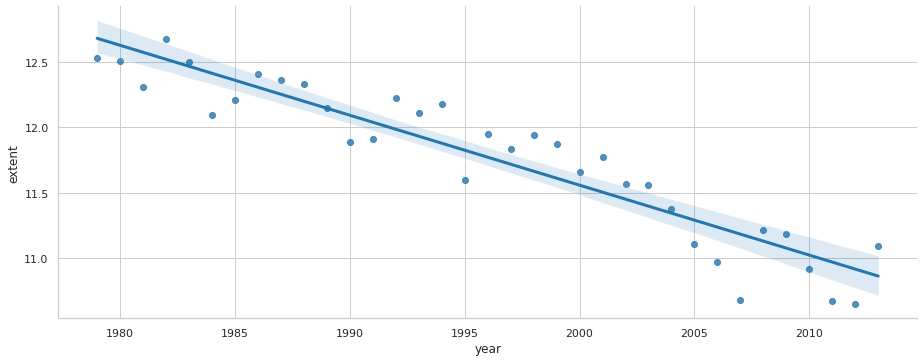

In [21]:
#Para visualizar los intervalos de confianza de la predicción utilizamos lmplot
#De nuevo observamos la tendencia negativa del SIE.
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth':2, 'font.family':[u'times']})
sns.lmplot(data=aux1, x='year', y='extent', height=5.2, aspect=2.5)

In [22]:
#Podemos intentar ajustar una recta mediante mínimos cuadrados
#a los datos mensuales originales de cada año. Pero, por lo visto
#al dibujar los datos año a año, la aproximación
#no será muy buena. De hecho, obtenemos un coeficiente
#de determinación igual a 0.4, que nos indica que el ajuste no es muy bueno.
#Además podemos intuir que septiembre y mayo son los meses de mayor y menor 
#variabilidad a lo largo de los años.
px.scatter(df, x = 'mo', y = 'extent',
           opacity=0.65, trendline='ols', 
           trendline_color_override='darkblue')

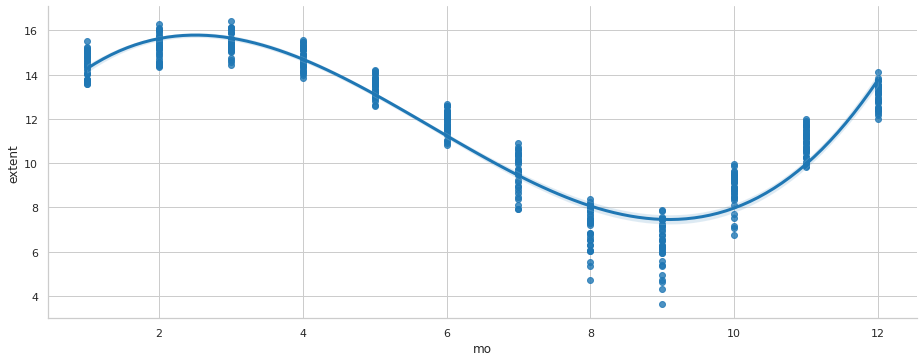

In [23]:
#Obtenemos un mejor resultado realizando un ajuste por
#mínimos cuadrados con un polinomio de tercer grado
sns.lmplot(data=df, x = 'mo', y = 'extent', height=5.2, aspect=2.5, order = 3)

In [24]:
#Un problema similar tenemos al intentar ajustar una recta
#a los datos de extent ordenados por fecha.
#Tenemos un coeficiente de determinación igual a 0.033
#Esto es debido al comportamiento estacional de extent.
fig = px.scatter(df, x = 'date', y = 'extent',
           opacity=0.65, trendline='ols', 
           trendline_color_override='darkblue')

fig.update_xaxes(rangeslider_visible = True)
fig.show()

In [25]:
#Finalmente obtenemos la media y la varianza de extent por cada mes.
#Obtenemos el resumen estadístico de extent agrupado por meses:
extent_summary = df.groupby(['mo']).describe().extent.reset_index()
extent_summary.head()

,mo,count,mean,std,min,25%,50%,75%,max
0,1,35.0,14.479429,0.552183,13.57,14.04,14.47,14.955,15.54
1,2,36.0,15.298889,0.543879,14.36,14.91,15.34,15.655,16.31
2,3,35.0,15.491714,0.487041,14.43,15.18,15.50,15.880,16.45
3,4,35.0,14.766000,0.464088,13.87,14.43,14.70,15.150,15.57
4,5,35.0,13.396000,0.435777,12.58,13.08,13.32,13.725,14.23


In [26]:
#Guardamos las medias.
#Como esperábamos, la mayor es la de marzo y la menor la de septiembre.
mo_means = extent_summary['mean']
print(mo_means)

0     14.479429
1     15.298889
2     15.491714
3     14.766000
4     13.396000
5     11.860000
6      9.601143
7      7.122286
8      6.404857
9      8.809143
10    10.964722
11    13.059429
Name: mean, dtype: float64


In [27]:
#Guardamos las varianzas.
#El mes de mayor variabilidad es septiembre y el de menos es mayo.
mo_var = extent_summary['std']**2
print(mo_var)

0     0.304906
1     0.295804
2     0.237209
3     0.215378
4     0.189901
5     0.247918
6     0.679175
7     0.824577
8     1.143902
9     0.630361
10    0.412511
11    0.284870
Name: std, dtype: float64


Normalize the SIE data: subtract the monthly mean and then convert to percent difference by dividing by the monthly mean and then multiplying by 100. Use the normalized SIE for the rest of the exercise.

In [28]:
#Obtenemos las medias de extent por mes correspondientes a cada fila de df
mo_means_df=mo_means[df['mo']-1].values

In [29]:
#Añadimos una nueva columna al dataframe con extent normalizado.
df['n_extent'] = (df['extent']- mo_means_df)/mo_means_df
df.head()

,year,mo,data_type,extent,area,date,n_extent
0,1979,1,Goddard,15.54,12.33,1979-01-01,0.073247
1,1980,1,Goddard,14.96,11.85,1980-01-01,0.033190
2,1981,1,Goddard,15.03,11.82,1981-01-01,0.038024
3,1982,1,Goddard,15.26,12.11,1982-01-01,0.053909
4,1983,1,Goddard,15.10,11.92,1983-01-01,0.042859


Visualize the trend of SIE per year considering:1) all months, 2) January, 3) August

In [30]:
#Aprovechando df1, podemos dibujar una regresión para los datos normalizados
#de cada mes a lo largo del tiempo.

mo_means_df1 = df1.groupby(['mo']).describe().extent.reset_index()['mean'][df1['mo']-1].values
df1['n_extent'] = (df1['extent']- mo_means_df1)/mo_means_df1

px.scatter(df1, x = 'year', y = 'n_extent',
  animation_frame = "mo", opacity = 0.65,
  trendline='ols', trendline_color_override='darkblue',
  range_y=[df1['n_extent'].min()-0.25,df1['n_extent'].max()+0.25],
  labels = {'mo': 'Month', 'extent':'Extent', 'year':'Year'})

In [31]:
#Al normalizar del modo en el que lo hemos hecho,
#se elimina el efecto de la estacionalidad y 
#obtenemos mejores predicciones.
#En la gráfica con year en el eje x hemos pasado de
#un coeficiente de determinación de 0.4 a uno de 0.51.
#En la que usa date, pasamos de 0.033 a 0.51.
px.scatter(df, x = 'year', y = 'n_extent',
           opacity=0.65, trendline='ols', 
           trendline_color_override='darkblue')

In [32]:
fig = px.scatter(df, x = 'date', y = 'n_extent',
           opacity=0.65, trendline='ols', 
           trendline_color_override='darkblue')

fig.update_xaxes(rangeslider_visible = True)
fig.show()

results = px.get_trendline_results(fig)

Calculate the Pearson correlation coefficient and the p-value for testing non-correlation of the SIE temporal trend (consider all months). Is it significant?

In [33]:
#Podemos obtener los datos a partir del último ajuste.
results.head()

,px_fit_results
0,<statsmodels.regression.linear_model.Regressio...


In [34]:
type(results['px_fit_results'][0])

statsmodels.regression.linear_model.RegressionResultsWrapper

In [35]:
#Teniendo en cuenta que R^2 = r^2, el coeficiente de correlación de Pearson es:
-np.sqrt(results['px_fit_results'][0].rsquared)
#Sabiendo que la relación entre las variables es negativa.

-0.715971456558494

In [36]:
#El p-valor asociado es:
results['px_fit_results'][0].f_pvalue
#Obtenemos un valor muy pequeño por lo que rechazamos la hipótesis de que
#no existe correlación entre las dos variables

1.539280743510228e-67

In [37]:
#También podemos obtener los valores utlizando las siguientes líneas:
from scipy.stats import pearsonr
df['num_date'] = df['year'] + ((df['mo']-1)*(1/12))
pearsonr(df['num_date'], df['n_extent'])

(-0.7159775875167703, 1.533456024637984e-67)

In [38]:
#Ya hemos visto que podemos acceder a los datos de la regresión que se 
#muestra en la última gráfica.
#La recta se ha construido utilizando la librería statsmodels,
#conviertiendo la fecha a datetime en formato unix epoch
#siguiendo los siguientes pasos:

datetimes=df['date'].astype('datetime64')
datetimes

0     1979-01-01
1     1980-01-01
2     1981-01-01
3     1982-01-01
4     1983-01-01
         ...    
417   2009-12-01
418   2010-12-01
419   2011-12-01
420   2012-12-01
421   2013-12-01
Name: date, Length: 422, dtype: datetime64[ns]

In [39]:
datetimes=datetimes.astype(int)
datetimes

0       283996800000000000
1       315532800000000000
2       347155200000000000
3       378691200000000000
4       410227200000000000
              ...         
417    1259625600000000000
418    1291161600000000000
419    1322697600000000000
420    1354320000000000000
421    1385856000000000000
Name: date, Length: 422, dtype: int64

In [40]:
y = df['n_extent']
x = datetimes/10**9
x = sm.add_constant(x)
model = sm.OLS(y, x)
fit = model.fit()

In [ ]:
#Los coeficientes de ambas regresiones son los mismos
#por lo tanto, son el mismo ajuste.
fit.params - results['px_fit_results'][0].params

const    8.326673e-17
date    -7.754818e-26
dtype: float64

In [41]:
#Una vez que sabemos como transforma las fechas, podemos utilizar
#los datos de la gráfica para completar el resto de apartados.

### 3. Compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

Provide the estimated parameters for the linear regression. 
Evaluate the quality of fit quantitatively and graphically.

In [42]:
fit0 = results['px_fit_results'][0]
fit0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     441.7
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           1.54e-67
Time:                        17:17:52   Log-Likelihood:                 638.32
No. Observations:                 422   AIC:                            -1273.
Df Residuals:                     420   BIC:                            -1265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1419      0.007     19.613      0.000       0.128       0.156
x1         -1.697e-10   8.08e-12    -21.018      0.000   -1.86e-10   -1.54e-10
==============================================================================
Omnibus:                      147.147   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1230.043
Skew:                          -1.245   Prob(JB):                    7.94e-268
Kurtosis:                      10.984   Cond. No.                     2.49e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
#Coeficientes
print(f'Constante:{fit0.params[0]}')
print(f'Pendiente:{fit0.params[1]}')

Constante:0.1419339021248528
Pendiente:-1.6974441830212723e-10


In [78]:
#Observamos que el ajuste no es demasiado bueno,
#pues obtenemos un coeficiente de determinación de valor 0.5
#En la gráfica observamos que la recta faya sobre todo al predecir
#los valores de los meses de verano, que son los que tienen una 
#variabilidad más grande.
print(f'R^2:{fit0.rsquared}')
print(f'Mean Squared Error:{fit0.mse_total}')
print(f'Mean Squared Error of the Model:{fit0.mse_model/422}')
print(f'Mean Squared Error of the Residuals:{fit0.mse_resid*420/422}')
print(f'Explained Variance Regression Score:{1-(fit0.resid.std()**2)/(df["n_extent"].std()**2)}')

R^2:0.5126151266064916
Mean Squared Error:0.005845877080661787
Mean Squared Error of the Model:0.0029895838704933407
Mean Squared Error of the Residuals:0.0028424404208777787
Explained Variance Regression Score:0.5137700670647704


### 4. Estimate the sea ice extent for January 2025

 Is there a negative trend in the evolution of sea ice extent over recent years? 

In [74]:
#Ya hemos visto que hay una tendencia negativa en la evolución de SIE 
#los últimos años. Obtengamos una predicción mediante nuestro modelo
#para la extent de enero de 2025

#primero adaptamos 01/01/2025 al formato de entrada de los datos de fecha del
#modelo
j_2025 = pd.to_datetime({'year' : [2025], 'month' : [1], 'day' : [1]}).values[0].astype('int')/10**9
j_2025

1735689600.0

In [75]:
#calculamos la predicción
fit0.predict([1, j_2025])[0]

-0.1526897193801991

In [76]:
#componemos con la inversa de la normalización
j_2025_extent = fit0.predict([1, j_2025])[0]*mo_means[0] + mo_means[0]

In [77]:
#y tenemos la predicción en millones de km cuadrados.
j_2025_extent

12.268568686071507